In [ ]:
!pip install keras -U


Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)


In [ ]:
!pip install coremltools -U


Requirement already up-to-date: coremltools in /usr/local/lib/python3.7/dist-packages (4.1)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import LayerNormalization
from keras.layers import Dropout
from keras.models import load_model
from keras.backend import clear_session
from keras.optimizers import Adam
from keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import tensorflow as tf
import gc
from sklearn.metrics import confusion_matrix


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [6]:
plt.rcParams["figure.figsize"] = (15,10)


## Test different window and stride sizes

In [7]:
def train_model(X_filepath, y_filepath, epochs, learning_rate, batch_size):
  X = np.load(X_filepath,allow_pickle=True)
  y = np.load(y_filepath, allow_pickle=True)

  r = np.random.permutation(len(X))
  X = X[r]
  y = y[r]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  weight_for_0 = (1 / (len(y_train)-sum(y_train))) * (len(y_train) / 2.0)
  weight_for_1 = (1 / sum(y_train)) * (len(y_train) / 2.0)
  class_weight = {0:weight_for_0,1:weight_for_1}
  #Model

  model = Sequential()
  model.add(LayerNormalization(axis=-1 , center=True , scale=True))
  model.add(Bidirectional(LSTM(int(X.shape[1]/2), return_sequences=True,stateful=False)))
  model.add(Dropout(.2))
  model.add(LayerNormalization(axis=-1 , center=True , scale=True))
  model.add(Bidirectional(LSTM(int(X.shape[1]/4), return_sequences=True,stateful=False)))
  model.add(Dropout(.2))
  model.add(LayerNormalization(axis=-1, center=True , scale=True))
  model.add(Bidirectional(LSTM(int(X.shape[1]/8), return_sequences=False,stateful=False)))
  model.add(Dropout(.2))
  model.add(LayerNormalization(axis=-1, center=True , scale=True))
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])
  # train LSTM
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2,validation_split=.1, class_weight=class_weight)
  # evaluate LSTM
  
  yhat = model.predict(X_test, verbose=2)
  metrics = model.evaluate(X_test,y_test)
  model.save('/content/drive/MyDrive/Capstone Project EDA/Model Saves/model_'+X_filepath[88:-9])
  
  plt.plot(history.history['loss'], label = 'Training Loss')
  plt.plot(history.history['val_loss'], label = 'Validation Loss')
  plt.legend()
  plt.title('Training and Validation Loss over '+str(epochs)+ ' Epochs '+X_filepath[88:-9])
  plt.savefig('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Loss_and_Accuracy_Plots/model_'+X_filepath[88:-4]+'_loss')
  plt.show()
  
  plt.plot(history.history['accuracy'],label = 'Training Accuracy')
  plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
  plt.legend()
  plt.title('Training and Validation Accuracy over '+str(epochs)+ ' Epochs '+X_filepath[88:-9])
  plt.savefig('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Loss_and_Accuracy_Plots/model_'+X_filepath[88:-4]+'_acc')
  plt.show()
  
  plt.plot(history.history['auc'],label = 'Training AUC_ROC')
  plt.plot(history.history['val_auc'], label = 'Validation AUC_ROC')
  plt.legend()
  plt.title('Training and Validation AUC_ROC over '+str(epochs)+ ' Epochs '+X_filepath[88:-9])
  plt.savefig('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Loss_and_Accuracy_Plots/model_'+X_filepath[88:-4]+'_auc')
  plt.show()
  del X
  del y
  clear_session()
  gc.collect()
  return metrics

In [7]:
Y_filepath = np.sort([f for f in listdir('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/Y_Datasets') if isfile(join('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/Y_Datasets', f))])
X_filepath = np.sort([f for f in listdir('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/X_Datasets') if isfile(join('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/X_Datasets', f))])
loss = []
auc = []
acc = []
window = []
stride = []
for X,y in zip(X_filepath,Y_filepath):
  metrics = train_model('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/X_Datasets/'+X,'/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/Y_Datasets/'+y, 300,1e-3,256)
  loss.append(metrics[0])
  acc.append(metrics[1])
  auc.append(metrics[2])
  window.append(X.split('_')[2])
  stride.append(X.split('_')[4])
metric_df = pd.DataFrame({'Window Size':window, 'Stride Size': stride, 'Acc': acc,'AUC ROC':auc, 'Loss':loss})
metric_df.to_csv('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/window_and_stride_comp.csv')
metric_df

KeyboardInterrupt: ignored

In [18]:
def user_cv(X_train_filepath, y_train_filepath, X_test_filepath,y_test_filepath,epochs, learning_rate, batch_size):
  X_train = np.load(X_train_filepath,allow_pickle=True)

  y_train = np.load(y_train_filepath, allow_pickle=True)
  X_test,X_val,y_test,y_val = train_test_split(np.load(X_test_filepath,allow_pickle=True),np.load(y_test_filepath, allow_pickle=True), test_size=0.33, random_state=42)
  print(X_val.shape,y_val.shape)
  weight_for_0 = (1 / (len(y_train)-sum(y_train))) * (len(y_train) / 2.0)
  weight_for_1 = (1 / sum(y_train)) * (len(y_train) / 2.0)
  class_weight = {0:weight_for_0,1:weight_for_1}
  #Model

  model = Sequential()
  model.add(LayerNormalization(axis=-1 , center=True , scale=True))
  model.add(Bidirectional(LSTM(int(X_train.shape[1]/2), return_sequences=True,stateful=False)))
  model.add(Dropout(.2))
  model.add(LayerNormalization(axis=-1 , center=True , scale=True))
  model.add(Bidirectional(LSTM(int(X_train.shape[1]/4), return_sequences=True,stateful=False)))
  model.add(Dropout(.2))
  model.add(LayerNormalization(axis=-1, center=True , scale=True))
  model.add(Bidirectional(LSTM(int(X_train.shape[1]/8), return_sequences=False,stateful=False)))
  model.add(Dropout(.2))
  model.add(LayerNormalization(axis=-1, center=True , scale=True))
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])
  # train LSTM
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2,validation_data=(X_val,y_val), class_weight=class_weight    )
  # evaluate LSTM
  
  yhat = model.predict(X_test, verbose=2)
  metrics = model.evaluate(X_test,y_test)
  model.save('/content/drive/MyDrive/Capstone Project EDA/Model Saves/model_'+X_train_filepath[-10]+'_batch')
  
  plt.plot(history.history['loss'], label = 'Training Loss')
  plt.plot(history.history['val_loss'], label = 'Validation Loss')
  plt.legend()
  plt.title('Training and Validation Loss over '+str(epochs)+ ' Epochs '+X_train_filepath[-10])
  plt.savefig('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Loss_and_Accuracy_Plots/model_'+X_train_filepath[-10]+'_loss')
  plt.show()
  
  plt.plot(history.history['accuracy'],label = 'Training Accuracy')
  plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
  plt.legend()
  plt.title('Training and Validation Accuracy over '+str(epochs)+ ' Epochs '+X_train_filepath[-10])
  plt.savefig('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Loss_and_Accuracy_Plots/model_'+X__train_filepath[-10]+'_acc')
  plt.show()
  
  plt.plot(history.history['auc'],label = 'Training AUC_ROC')
  plt.plot(history.history['val_auc'], label = 'Validation AUC_ROC')
  plt.legend()
  plt.title('Training and Validation AUC_ROC over '+str(epochs)+ ' Epochs '+X_train_filepath[-10])
  plt.savefig('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Loss_and_Accuracy_Plots/model_'+X_train_filepath[-10]+'_auc')
  plt.show()
  metric_df = pd.DataFrame({'Fold':X_train_filepath[-10],'Test Loss':metric[0],'Test Accuracy':metric[1],'Test AUC_ROC':metric[2]})
  metric_df.to_csv('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/user_cv_'+X_train_filepath[-10]+'.csv')


  clear_session()
  gc.collect()
  return metrics

In [16]:
X_train_filepath = np.sort([f for f in listdir('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets/X_train') if isfile(join('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets/X_train', f))])
Y_train_filepath = np.sort([f for f in listdir('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets/Y_train') if isfile(join('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets/Y_train', f))])
X_test_filepath = np.sort([f for f in listdir('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets/X_test') if isfile(join('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets/X_test', f))])
Y_test_filepath = np.sort([f for f in listdir('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets/Y_test') if isfile(join('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets/Y_test', f))])

loss = []
auc = []
acc = []
window = []
stride = []
for X_train,y_train,X_test,y_test in zip(X_train_filepath,Y_train_filepath,X_test_filepath,Y_test_filepath):
  print(X_train)
  metrics = user_cv('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets/X_train/'+X_train,
                        '/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets/Y_train/'+y_train,
                        '/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets/X_test/'+X_test,
                        '/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets/Y_test/'+y_test,
                        300,1e-3,512)



X_fold_0_data.npy
(31995, 400, 3) (31995,)


ValueError: ignored

In [ ]:
X_train_filepath = np.sort([f for f in listdir('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets_5000/X_train') if isfile(join('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets_5000/X_train', f))])
Y_train_filepath = np.sort([f for f in listdir('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets_5000/Y_train') if isfile(join('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets_5000/Y_train', f))])
X_test_filepath = np.sort([f for f in listdir('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets_5000/X_test') if isfile(join('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets_5000/X_test', f))])
Y_test_filepath = np.sort([f for f in listdir('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets_5000/Y_test') if isfile(join('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets_5000/Y_test', f))])

loss = []
auc = []
acc = []
window = []
stride = []
for X_train,y_train,X_test,y_test in zip(X_train_filepath,Y_train_filepath,X_test_filepath,Y_test_filepath):
  print(X_train)
  metrics = user_cv('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets_5000/X_train/'+X_train,
                        '/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets_5000/Y_train/'+y_train,
                        '/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets_5000/X_test/'+X_test,
                        '/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/By_Ind_Datasets_5000/Y_test/'+y_test,
                        300,1e-3,512)



X_fold_0_data.npy
(6403, 400, 3) (6403,)
Epoch 1/300


## Original model building


In [ ]:
r = np.random.permutation(len(X))
X = X[r]
y = y[r]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
weight_for_0 = (1 / (len(y_train)-sum(y_train))) * (len(y_train) / 2.0)
weight_for_1 = (1 / sum(y_train)) * (len(y_train) / 2.0)
class_weight = {0:weight_for_0,1:weight_for_1}

In [ ]:
#Model

model = Sequential()

model.add(LayerNormalization(axis=-1 , center=True , scale=True))
model.add(Bidirectional(LSTM(100, return_sequences=True,stateful=False)))

model.add(Dropout(.2))
model.add(LayerNormalization(axis=-1 , center=True , scale=True))
model.add(Bidirectional(LSTM(50, return_sequences=True,stateful=False)))
model.add(Dropout(.2))

model.add(LayerNormalization(axis=-1, center=True , scale=True))
model.add(Bidirectional(LSTM(25, return_sequences=False,stateful=False)))
model.add(Dropout(.2))

model.add(LayerNormalization(axis=-1, center=True , scale=True))


model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])
# train LSTM
history = model.fit(X_train, y_train, epochs=300, batch_size=256, verbose=2,validation_split=.1, class_weight=class_weight)
# evaluate LSTM
yhat = model.predict(X_test, verbose=2)
model.evaluate(X_test,y_test)


Epoch 1/300
276/276 - 60s - loss: 0.5532 - accuracy: 0.7070 - auc: 0.7816 - val_loss: 0.5686 - val_accuracy: 0.7110 - val_auc: 0.8083
Epoch 2/300
276/276 - 47s - loss: 0.5168 - accuracy: 0.7177 - auc: 0.8047 - val_loss: 0.5208 - val_accuracy: 0.7293 - val_auc: 0.8028
Epoch 3/300
276/276 - 46s - loss: 0.5178 - accuracy: 0.7160 - auc: 0.8037 - val_loss: 0.4932 - val_accuracy: 0.7334 - val_auc: 0.8183
Epoch 4/300
276/276 - 47s - loss: 0.5101 - accuracy: 0.7168 - auc: 0.8083 - val_loss: 0.5398 - val_accuracy: 0.7207 - val_auc: 0.8086
Epoch 5/300
276/276 - 46s - loss: 0.5058 - accuracy: 0.7209 - auc: 0.8099 - val_loss: 0.5165 - val_accuracy: 0.7329 - val_auc: 0.8267
Epoch 6/300
276/276 - 46s - loss: 0.4968 - accuracy: 0.7272 - auc: 0.8195 - val_loss: 0.5211 - val_accuracy: 0.7288 - val_auc: 0.8267
Epoch 7/300
276/276 - 47s - loss: 0.5009 - accuracy: 0.7197 - auc: 0.8189 - val_loss: 0.5708 - val_accuracy: 0.6892 - val_auc: 0.8028
Epoch 8/300
276/276 - 46s - loss: 0.4984 - accuracy: 0.7270 - 

[0.1669636368751526, 0.9575294852256775, 0.9825380444526672]

In [ ]:
model.save('/content/drive/MyDrive/Capstone Project EDA/Model Saves/model_100_50_25')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone Project EDA/Model Saves/model_100_50_25/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone Project EDA/Model Saves/model_100_50_25/assets


## Load best performing window and stride size

In [ ]:
model = load_model('/content/drive/MyDrive/Capstone Project EDA/Model Saves/model_window_10000_stride_1000')


In [ ]:
X = np.load('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/X_Datasets/X_window_10000_stride_1000_data.npy', allow_pickle = True)
y = np.load('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/Y_Datasets/Y_window_10000_stride_1000_data.npy', allow_pickle = True)

In [ ]:
r = np.random.permutation(len(X))
X = X[r]
y = y[r]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
yhat = model.predict(X_test, verbose=2)
yhat

3017/3017 - 228s


array([[9.9971372e-01],
       [3.2437342e-08],
       [8.3666984e-03],
       ...,
       [4.6287700e-05],
       [5.1339410e-02],
       [9.9952185e-01]], dtype=float32)

In [ ]:
#Confusion matrix
confusion_matrix(y_test,np.array(yhat.flatten()>.5, dtype=int), normalize = 'true')


array([[0.98941163, 0.01058837],
       [0.04271605, 0.95728395]])

In [ ]:
plt.rcParams["figure.figsize"] = (35,10)


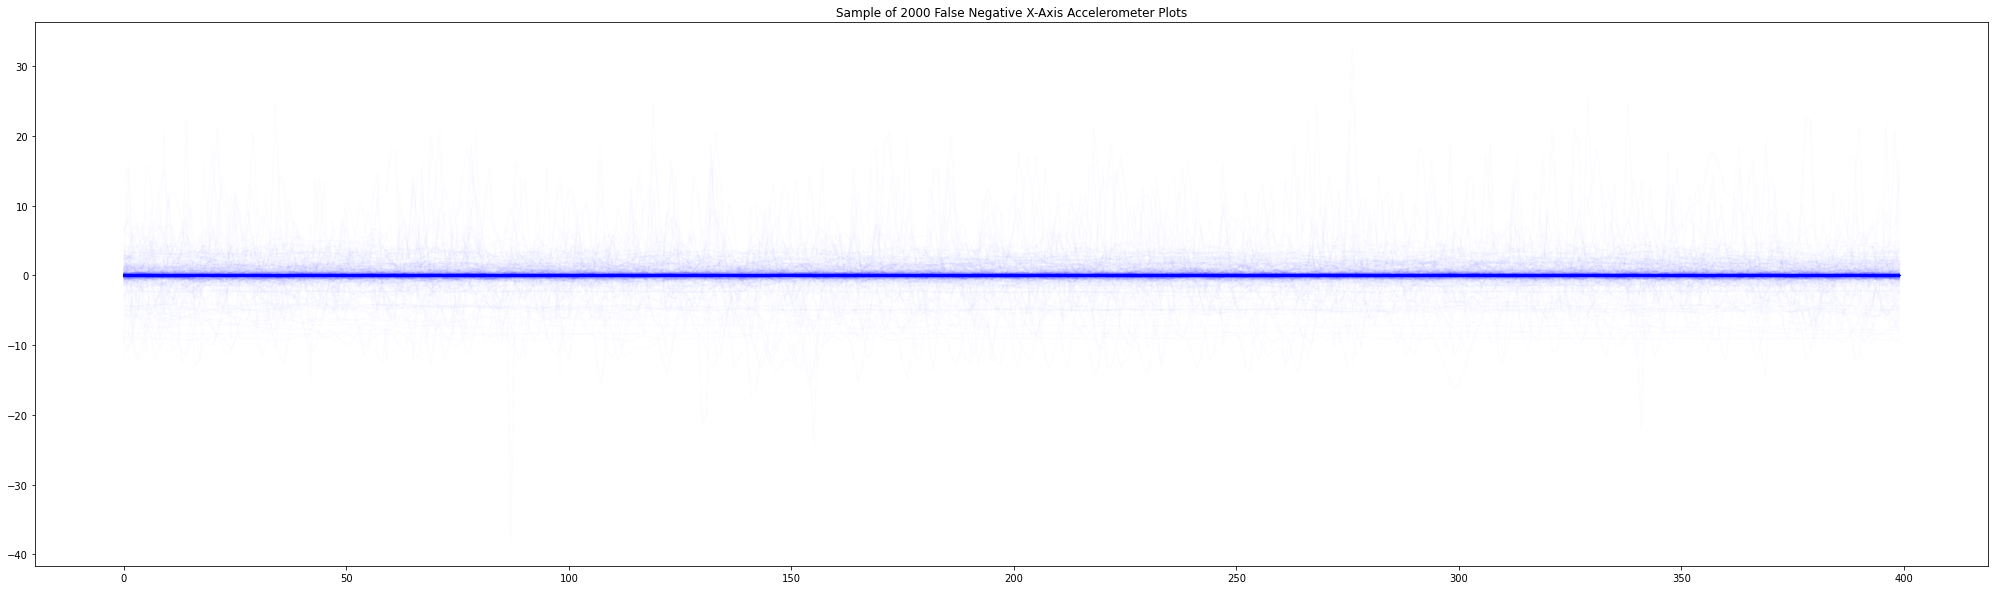

In [ ]:
for x in X_train[np.where((np.array(yhat.flatten()<.5, dtype=int)==y_test)==False)[0]][:2000]:
    plt.plot(np.arange(len(x)), x[:,0], color = 'blue',alpha = .01)
plt.title('Sample of 2000 False Negative X-Axis Accelerometer Plots')
plt.savefig('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/False Negative Plots/fn_x_graph')




plt.show()


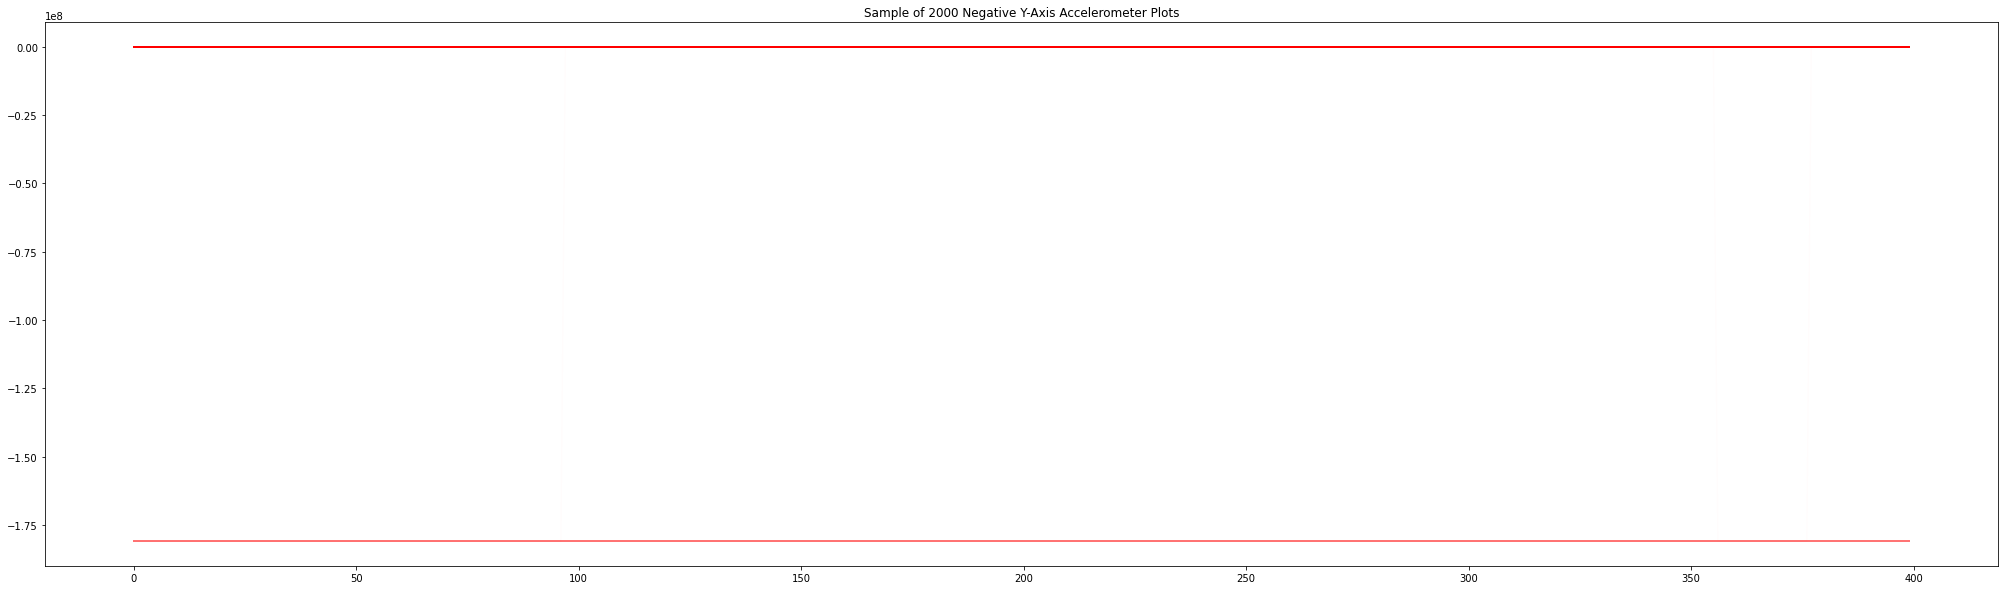

In [ ]:
for x in X_train[np.where((np.array(yhat.flatten()<.5, dtype=int)==y_test)==False)[0]][:2000]:
    plt.plot(np.arange(len(x)), x[:,1], color = 'red',alpha = .01)
plt.title('Sample of 2000 Negative Y-Axis Accelerometer Plots')
plt.savefig('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/False Negative Plots/fn_y_graph')
plt.show()


0.4831999999999999
2.4288000000000016
0.960600000000001
0.3714999999999999
-1.3174999999999986
-123.74362695890008
2.317700000000001
0.2528000000000006
-2.124499999999999
216.85043791999988
-1.5264999999999997
1.3191999999999986
3.6486000000000005
4.096000000000003
224.82451505
224.2700056000001
-0.23049999999999987
-4.160900000000003
-50.769787137099954
0.25019999999999953
3.781900000000006
9.106699999999996
-8.523100000000001
-56.320690852229944
1.6525999999999998
-127.10516144966998
4.178499999999997
217.54486219999984
1.8444999999999971
157.6996000000001
-5.038500000000003
2.978500000000004
182.70935331139998
222.83788291000022
1.0385999999999986
1.3459999999999992
2.6869999999999976
2.9123000000000014
222.73339115999985
1.9509000000000016
-1.5411000000000008
224.00212278000006
1.0306000000000002
-1.9506999999999988
2.354300000000002
72360305616.0
3.260700000000003
6.312100000000002
-1.9440000000000015
223.59959497000008
-52.002915502499974
72360302016.0
2.4935999999999994
1.393100

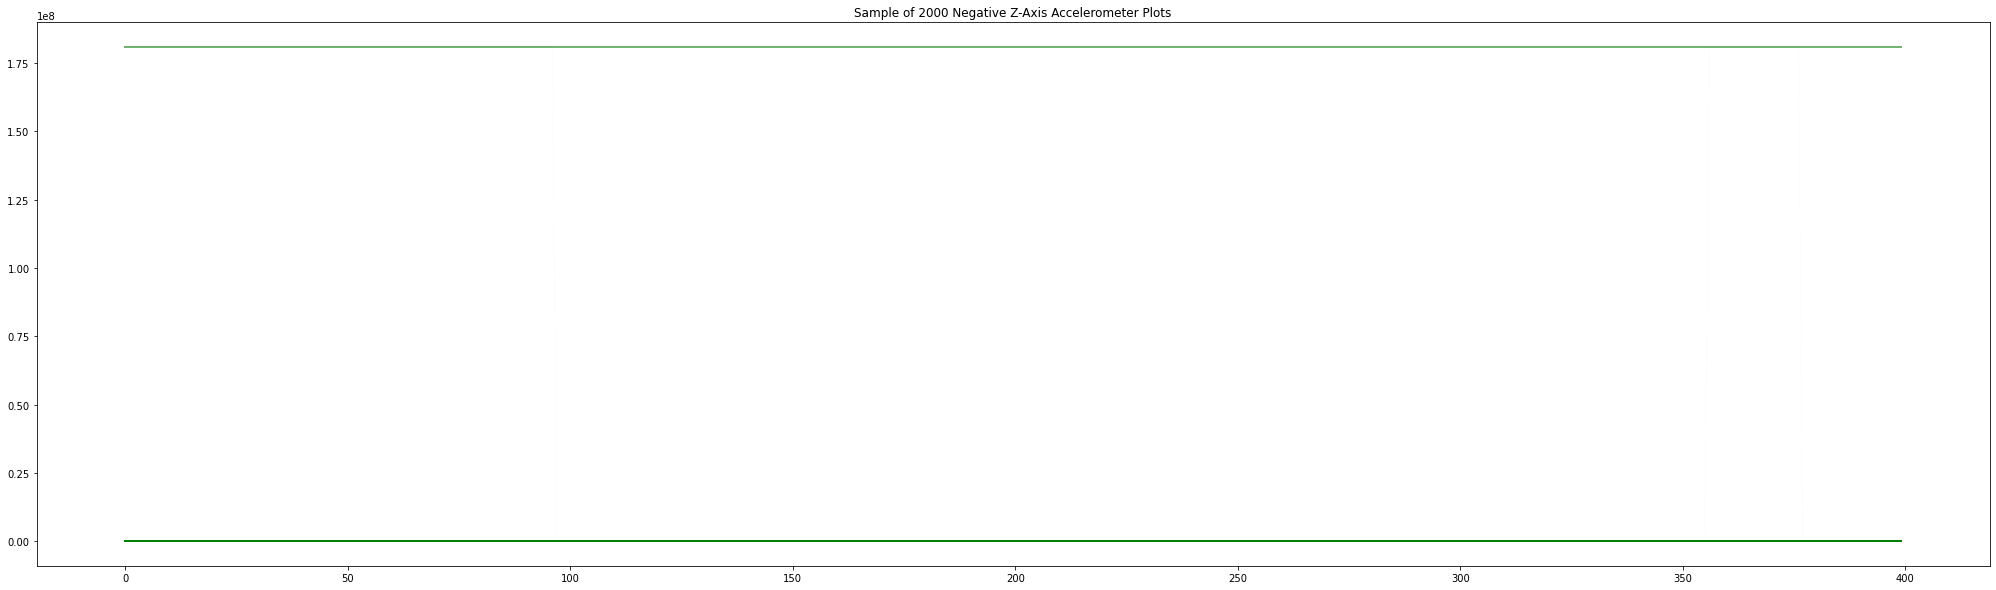

In [ ]:
for x in X_train[np.where((np.array(yhat.flatten()<.5, dtype=int)==y_test)==False)[0]][:2000]:
    print(sum(x[:,2]))
    plt.plot(np.arange(len(x)), x[:,2], color = 'green',alpha = .01)
plt.title('Sample of 2000 Negative Z-Axis Accelerometer Plots')
plt.savefig('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/False Negative Plots/fn_z_graph')
plt.show()


## Port Keras model to CoreML model

In [ ]:
model.save('/content/drive/MyDrive/Capstone Project EDA/Model Saves/model_window_10000_stride_1000.h5')

In [ ]:
model

In [ ]:

converter = coremltools.converters.keras.convert('/content/drive/MyDrive/Capstone Project EDA/Model Saves/model_window_10000_stride_1000.h5',
                                                 input_names=['accel_data'],
                                                 output_names=['output'], 
                                                  class_labels=[0,1])
converter.save('BiLSTM_model.mlmodel')


ValueError: ignored